## Ejercicio técnico - Etermax AI Labs - Consultor I.A.
### Rocío Carro

#### Objetivo: Determinar los tópicos predominantes en cada conversación del corpus adjunto

##### Notas y lineamientos:
* Se adjunta corpus (en formato csv) compuesto por la desgrabación de 640 llamadas
* Cada desgrabación corresponde a un llamado en el que interviene un cliente y un agente de un contact center
* El lenguaje a utilizar es Python, y se debe entregar una Notebook en donde se puedan visualizar todos los pasos ejecutados, desde la carga del corpus, hasta la predicción de cada conversación realizada por el modelo.
* Se pueden utilizar las librerías y técnicas que se consideren, no hay limitación en cuanto a este punto.
* El código deberá ser compartido a través de una cuenta de Git.


### Ejercicio:

#### 1. Carga de librerias
Importar librerias para manipular los datos, modelar tópicos, tokenizar, descargar stopwords, hacer gráficos, etc.


In [11]:
import pandas as pd
import os
from unidecode import unidecode
import re

import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import gensim
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### 2. Carga y unificación de datos
Importar el corpus de csv, compuesto por las 640 desgrabaciones, y unificar para crear un dataframe para trabajar.

In [12]:
#Importar carpeta con los archivos.
corpus = "C:/Users/Usuario/Desktop/Ejercicio_tecnico_Consultor_IA/Ejercicio/Corpus"

#Crear un df vacio para luego guardar los textos de cada conversación.
corpus_unificado = pd.DataFrame()

#Recorrer cada uno de los archivos que finalizan con .csv en la carpeta indicada.
for archivo in os.listdir(corpus):
 if archivo.endswith('.csv'):
        pathcompleto = os.path.join(corpus, archivo) #Concatenar la ruta de la carpeta con cada archivo para construir la ruta completa de cada uno.
        df_c = pd.read_csv(pathcompleto, sep = "|") #Leer los archivos csv y crear un dataframe, indicando | como delimitación. 
        df_c.rename(columns={'Pregunta': 'Texto'}, inplace=True) #Renombrar columna.
        df_c["Archivo"] = archivo #Agregar una columna con el nombre del archivo al que pertenece el texto.
        corpus_unificado = pd.concat([corpus_unificado, df_c], ignore_index = True) #Finalmente, concatenar para unificar todo en un solo df.
    
#Ver el df generado.
print(corpus_unificado)


                                                 Texto             Archivo
0     Hola , mi nombre es Valeria . Disculpe , no e...  34701-10-07-17.csv
1     Buenas tardes . punto Mi nombre es José Gutié...  34701-12-31-48.csv
2     Hola . Buenas tardes . Habla con María Azcára...  34701-12-57-22.csv
3     Buenas tardes , Francisco Moreno . , que mire...  34701-13-27-47.csv
4     al final . Hola , buenas tardes con Karen . M...  34701-13-56-30.csv
..                                                 ...                 ...
635   barba . Buenas tardes . . tengo una consulta ...  34809-12-21-48.csv
636   Hola . Buenos días . Mi nombre es Paola . Le ...  34809-12-37-51.csv
637   Buenas tardes . Bienvenido . . mi nombre es E...  34809-12-42-09.csv
638   . Mira , tengo una pura . Es una compra onlin...  34809-12-45-28.csv
639   Buenas tardes . Bienvenida . Mi nombre es Edu...  34809-13-53-07.csv

[640 rows x 2 columns]


#### 3. Preprocesamiento y tokenización

Filtrar stopwords, dígitos y palabras con poco valor de análisis. Realizar la tokenización, es decir, la división de una secuencia textual en tokens para su posterior procesamiento.

In [13]:
#Garantizar que todos los elementos de la columna Texto del df sean cadenas de texto y no listas.
corpus_unificado['Texto'] = corpus_unificado['Texto'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

#Para normalizar el texto, crear una función que convierta el texto a minúsculas y elimine acentos, dígitos y símbolos.
def normalizar_texto(texto):
    quitar_acentos = unidecode(texto)
    texto_normalizado = re.sub(r'[^a-zA-Z0-9\s]', '', quitar_acentos.lower())
    return texto_normalizado

#Aplicar la función a la columna 'Texto' del df de trabajo.
corpus_unificado['Texto'] = corpus_unificado['Texto'].apply(normalizar_texto)

#Traer stopwords de las librerias NLTK y Spicy, unificarlas para hacer una lista más completa.
stopwords_nltk = set(stopwords.words('spanish'))

nlp = spacy.load("es_core_news_sm")
stopwords_spacy = set(spacy.lang.es.stop_words.STOP_WORDS)

#Agregar otras palabras que tienen poco valor de análisis y, luego, unificar todo.
sw_extras = {"hola", "nombre", "buenas", "tardes", "dias", "dia", "gracias", "muchas", "nombre", "tardes", "disculpe", "mire", "cero", "uno", "dos", "tres", "cuatro", 
             "cinco", "seis", "siete", "ocho", "nueve", "bienvenido", "bienvenidos", "mira", "favor", "mil", "manana", "treinta", "cuarenta", "cosas", "cosa", "pasa", 
             "hice", "momento", "ciento", "cincuenta", "noventa", "setenta", "okay", "alo", "aca", "gusto", "ayer", "senora", "perfecto", "jota", "eme"}

fullstopwords = stopwords_nltk.union(stopwords_spacy, sw_extras)

#Quitar stopwords del texto y tokenizar.
corpus_unificado['Texto'] = corpus_unificado['Texto'].apply(lambda texto: [word for word in word_tokenize(texto) if word.lower() not in fullstopwords]) 

#Ver el df con el texto tokenizado.
print(corpus_unificado)

                                                 Texto             Archivo
0    [valeria, escuche, jose, jose, constantemente,...  34701-10-07-17.csv
1    [punto, jose, gutierrez, hablar, simona, dije,...  34701-12-31-48.csv
2    [maria, azcarate, consulta, demorando, despach...  34701-12-57-22.csv
3    [francisco, moreno, pedidos, paginas, pedido, ...  34701-13-27-47.csv
4    [karen, quiero, pregunta, maquina, arepa, apar...  34701-13-56-30.csv
..                                                 ...                 ...
635  [barba, consulta, pedido, iba, llegar, viernes...  34809-12-21-48.csv
636  [paola, quiero, consulta, acabo, compra, onlin...  34809-12-37-51.csv
637  [eduardo, hablar, avisar, ayudar, llamo, cance...  34809-12-42-09.csv
638  [pura, compra, online, semana, producto, pendi...  34809-12-45-28.csv
639  [bienvenida, eduardo, hablar, jose, ayudar, pe...  34809-13-53-07.csv

[640 rows x 2 columns]


#### 4. Palabras más frecuentes

Antes del modelado de tópicos, visualizar las palabras más frecuentes en la totalidad del corpus para tener una primera aproximación al contenido de los datos.

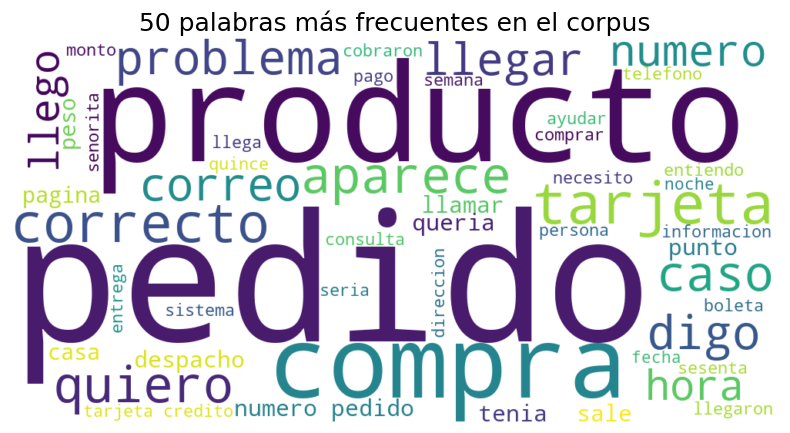

In [14]:
#Concatenar en una cadena todo la columna de texto.
textocombinado = ' '.join(corpus_unificado['Texto'].astype(str)).replace("'", "")

#Para ver cuales son las palabras más utilizadas en todo el corpus, crear un wordcloud con las 50 más frecuentes.
wordcloud = WordCloud(width = 1000, height = 500, max_words = 50, background_color = 'white').generate(textocombinado)

#Visualizar la wordcloud creada.
plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('50 palabras más frecuentes en el corpus', fontsize = 18)
plt.axis('off')
plt.show()


#### 5. Topic Modeling

Para poder determinar los tópicos de las conversaciones del corpus, utilizar la técnica probabilística de modelado de tópicos Latent Dirichlet Allocation (LDA).

In [15]:
#En principio, crear un diccionario que vincule cada palabra única dentro del df a un id único.
diccionario = corpora.Dictionary(corpus_unificado['Texto'])

#A partir del diccionario, crear un corpus de documentos que convierta el diccionario en una bolsa de palabras (doc2bow -bag of words-) y, a partir de esto, otorgar al modelo LDA la frecuencia de cada palabra en el documento de texto.
corpus_lda = [diccionario.doc2bow(text) for text in corpus_unificado['Texto']]

#Entrenar modelo LDA, indicando la cantidad de tópicos, pases e iteraciones deseadas.
modelo_lda = models.LdaModel(corpus_lda, num_topics = 5, id2word = diccionario, passes = 15, alpha = 0.01, iterations = 100, random_state = 100)
##Nota: se probó el modelo con distintos números de tópicos y se consideró que 5 era el número adecuado, ya que más cantidad generaba muchos tópicos superpuestos entre sí.

#Ver los 5 tópicos con las 10 palabras más representativas de cada uno.
topicos = modelo_lda.print_topics(num_words = 10)
for topic in topicos:
    print(topic)

(0, '0.029*"tarjeta" + 0.022*"pedido" + 0.020*"compra" + 0.013*"credito" + 0.008*"numero" + 0.008*"aparece" + 0.007*"pagina" + 0.006*"quiero" + 0.006*"digo" + 0.006*"sale"')
(1, '0.029*"pedido" + 0.013*"tarjeta" + 0.012*"correo" + 0.011*"compra" + 0.009*"numero" + 0.008*"problema" + 0.007*"productos" + 0.007*"producto" + 0.006*"quiero" + 0.005*"punto"')
(2, '0.047*"pedido" + 0.018*"numero" + 0.009*"compra" + 0.008*"llegar" + 0.008*"producto" + 0.008*"llamar" + 0.008*"correcto" + 0.007*"productos" + 0.006*"tiempo" + 0.006*"punto"')
(3, '0.016*"pedido" + 0.015*"numero" + 0.013*"productos" + 0.010*"producto" + 0.008*"correo" + 0.008*"caso" + 0.008*"unidades" + 0.008*"devolucion" + 0.007*"correcto" + 0.007*"informacion"')
(4, '0.009*"llego" + 0.007*"llamar" + 0.005*"problema" + 0.005*"pedido" + 0.005*"compra" + 0.004*"seria" + 0.004*"llega" + 0.004*"solucion" + 0.004*"amable" + 0.004*"llamado"')


#### 6. Visualización de los tópicos

Graficar los tópicos obtenidos tras el entrenamiento del modelo LDA.

In [16]:
#Crear una visualización interactiva de los tópicos que permite explorar las palabras más relevantes para cada tópico (Term Frequency), la distribución de las palabras dentro de cada uno y la similitud entre tópicos.
graf_topicos = gensimvis.prepare(modelo_lda, corpus_lda, diccionario, sort_topics = False)

#Ver gráfico creado.
pyLDAvis.display(graf_topicos)

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Li

#### 7. Tópicos predominantes en cada conversación

Finalmente, determinar los tópicos predominantes en cada conversación del corpus trabajado.

In [17]:
#Calcular las probabilidades de pertenencia de cada tópico a cada conversación del corpus, buscando el tópico con la probabilidad más alta para cada una.
distribucion_topicos = [max(probabilidades, key = lambda x: x[1]) for probabilidades in modelo_lda[corpus_lda]]

#En base al df inicial de trabajo, crear uno nuevo con una columna que indique el tópico con mayor probabilidad para cada conversación.
topicoxconversacion = corpus_unificado.copy()
topicoxconversacion['Tópico'] = [t[0] for t in distribucion_topicos]

#Agregar una columna para las palabras más representativas del tópico.
topicoxconversacion['Palabras representativas del tópico'] = ['' for _ in range(len(topicoxconversacion))]

#Iterar sobre cada conversación y obtener las 10 palabras más asociadas al tópico con mayor probabilidad para cada una.
for i, doc in enumerate(modelo_lda[corpus_lda]):
    topico_mas_probable = max(doc, key=lambda x: x[1])[0]
    palabras_asociadas = ', '.join([palabra[0] for palabra in modelo_lda.show_topic(topico_mas_probable, topn = 10)])
    topicoxconversacion.at[i, 'Palabras representativas del tópico'] = palabras_asociadas

#Ver df con el topico más probable por conversación.
print(topicoxconversacion)

                                                 Texto             Archivo  \
0    [valeria, escuche, jose, jose, constantemente,...  34701-10-07-17.csv   
1    [punto, jose, gutierrez, hablar, simona, dije,...  34701-12-31-48.csv   
2    [maria, azcarate, consulta, demorando, despach...  34701-12-57-22.csv   
3    [francisco, moreno, pedidos, paginas, pedido, ...  34701-13-27-47.csv   
4    [karen, quiero, pregunta, maquina, arepa, apar...  34701-13-56-30.csv   
..                                                 ...                 ...   
635  [barba, consulta, pedido, iba, llegar, viernes...  34809-12-21-48.csv   
636  [paola, quiero, consulta, acabo, compra, onlin...  34809-12-37-51.csv   
637  [eduardo, hablar, avisar, ayudar, llamo, cance...  34809-12-42-09.csv   
638  [pura, compra, online, semana, producto, pendi...  34809-12-45-28.csv   
639  [bienvenida, eduardo, hablar, jose, ayudar, pe...  34809-13-53-07.csv   

     Tópico                Palabras representativas del tópico 

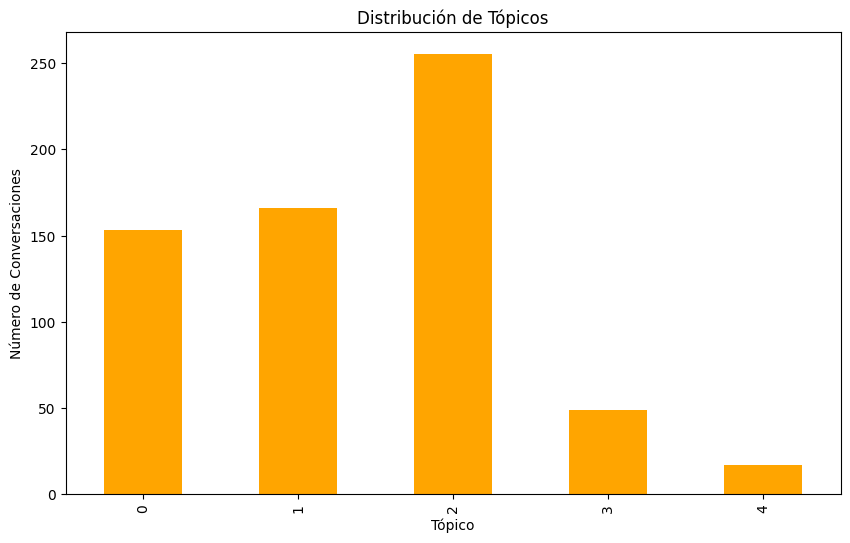

In [18]:
#Graficar la distribución de tópicos en las conversaciones para ver más claramente cuál es el que presenta mayor probabilidad en el total del corpus trabajado.
plt.figure(figsize = (10, 6))
topicoxconversacion['Tópico'].value_counts().sort_index().plot(kind = 'bar', color = 'orange')
plt.title('Distribución de Tópicos')
plt.xlabel('Tópico')
plt.ylabel('Número de Conversaciones')
plt.show()

In [19]:
#Por último, si, además del tópico más probable, se desea ver los otros tópicos predominantes en cada caso podemos obtener las probabilidades de pertenencia de cada tópico a cada conversación.
probabilidades_topicos = [dict(probabilidades) for probabilidades in modelo_lda[corpus_lda]]
probabilidades_df = pd.DataFrame(probabilidades_topicos).fillna(0) #Cargar probabilidades en un df.

#Organizar columnas de tópicos.
columnas_ordenadas = [i for i in range(len(modelo_lda.print_topics()))]
probabilidades_df = probabilidades_df[columnas_ordenadas]

#Concatenar esta información con el df de los tópicos más probables.
txc_probabilidades = pd.concat([topicoxconversacion, probabilidades_df], axis=1)

#Ver df final.
print(txc_probabilidades)

                                                 Texto             Archivo  \
0    [valeria, escuche, jose, jose, constantemente,...  34701-10-07-17.csv   
1    [punto, jose, gutierrez, hablar, simona, dije,...  34701-12-31-48.csv   
2    [maria, azcarate, consulta, demorando, despach...  34701-12-57-22.csv   
3    [francisco, moreno, pedidos, paginas, pedido, ...  34701-13-27-47.csv   
4    [karen, quiero, pregunta, maquina, arepa, apar...  34701-13-56-30.csv   
..                                                 ...                 ...   
635  [barba, consulta, pedido, iba, llegar, viernes...  34809-12-21-48.csv   
636  [paola, quiero, consulta, acabo, compra, onlin...  34809-12-37-51.csv   
637  [eduardo, hablar, avisar, ayudar, llamo, cance...  34809-12-42-09.csv   
638  [pura, compra, online, semana, producto, pendi...  34809-12-45-28.csv   
639  [bienvenida, eduardo, hablar, jose, ayudar, pe...  34809-13-53-07.csv   

     Tópico                Palabras representativas del tópico 